In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

# z filters (grande):

object_z_filters = ['photoz_mean < 1.5', (np.isfinite, 'photoz_mean')]

truth_z_filters = ['redshift < 1.5', (np.isfinite, 'redshift')] 

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters+object_z_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters+truth_z_filters, 
                                      native_filters=healpix_filter))

In [9]:
list(truth_data)

['mag_i',
 'is_central',
 'redshift',
 'ra',
 'dec',
 'halo_id',
 'halo_mass',
 'galaxy_id']

In [10]:
truth_data['halo_mass']

array([5.07006249e+12, 5.07006249e+12, 3.79915201e+10, ...,
       1.28993621e+10, 4.89915741e+10, 2.66634575e+10])

In [11]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2038017
nombre de galaxies centrales = 1884055
pourcentage de galaxies centrales = 92.44549971859901 %
nombre d'objets = 560402


(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 [Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

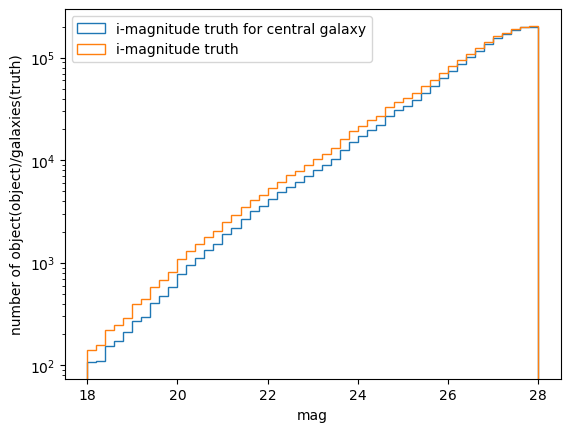

In [12]:
plt.figure()
truth_hist_central=plt.hist(truth_data['mag_i'][np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='i-magnitude truth for central galaxy', log=True)
truth_hist=plt.hist(truth_data['mag_i'], bins=50, histtype='step', label='i-magnitude truth', log=True)
plt.legend()
plt.xlabel('mag')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07]),
 [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

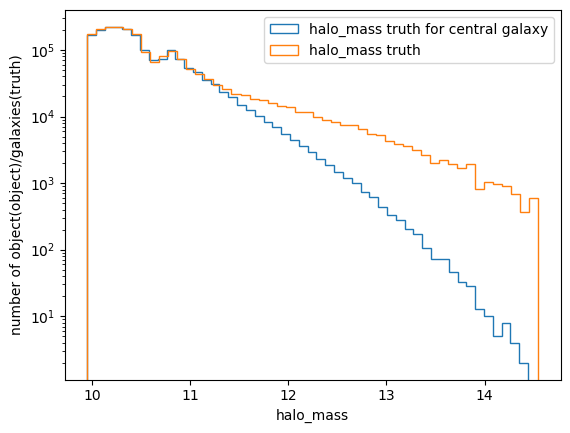

In [13]:
plt.figure()
truth_hist_central=plt.hist(np.log10(truth_data['halo_mass'])[np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='halo_mass truth for central galaxy', log=True)
truth_hist=plt.hist(np.log10(truth_data['halo_mass']), bins=50, histtype='step', label='halo_mass truth', log=True)
plt.legend()
plt.xlabel('halo_mass')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

### FoF algo :

In [14]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [15]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                  linking_lengths=my_linking_length)

In [16]:
results

row_index,catalog_key,group_id
int64,str6,int64
0,object,0
1887873,galaxy,0
1,object,1
488379,galaxy,1
2,object,2
485145,galaxy,2
3,object,3
640537,galaxy,3
4,object,4


In [17]:
results[results['row_index']==1] #FoF assemble les tab truth et data mais les mélanges pas

row_index,catalog_key,group_id
int64,str6,int64
1,object,1
1,galaxy,234434


In [18]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [19]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

2073281


#### Galaxy central selection :

In [20]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)

In [21]:
ind_galax_truth = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)

In [22]:
n_truth_central=np.bincount(results[truth_mask][ind_galax_truth]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

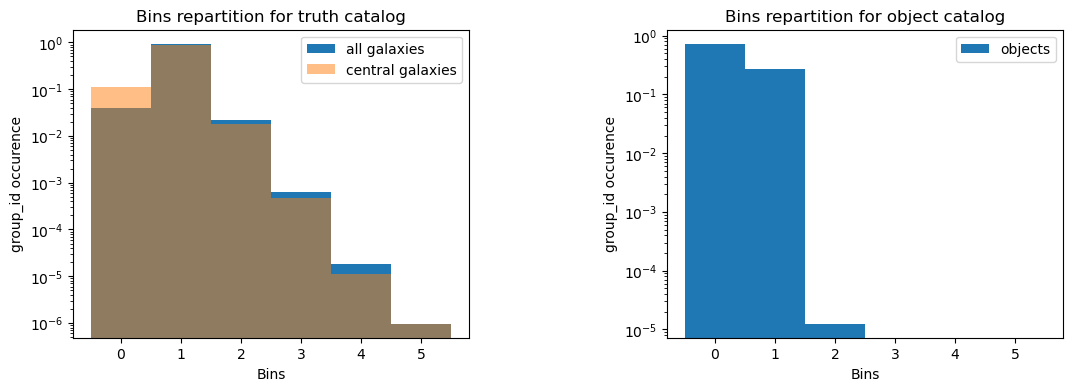

In [23]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1central=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2central=plt.hist(n_truth_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True, label='central galaxies')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for truth catalog')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for object catalog')

plt.show()

In [25]:
print(hist1central[0])
print(hist2central[0])

[3.99222103e-02 9.37842995e-01 2.15769008e-02 6.38601020e-04
 1.83284281e-05 9.64654109e-07]
[1.10137454e-01 8.71491191e-01 1.78875811e-02 4.71715859e-04
 1.10935223e-05 9.64654109e-07]


Histogramme normalisé. Quand on enlève les galaxies satellites on observe une 

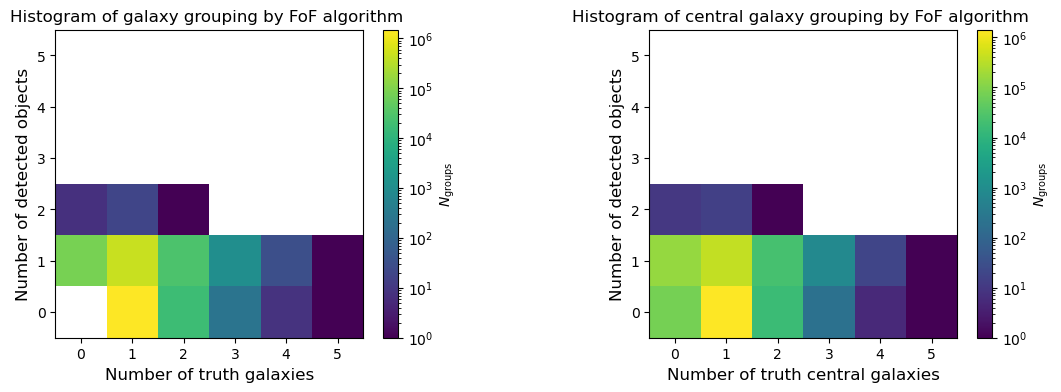

In [26]:
#average number of galaxies by groupsplt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2central=plt.hist2d(n_truth_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth_central))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth central galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of central galaxy grouping by FoF algorithm ')

plt.show()

#attention histo en échelles log

Remarque :

* Apparation en grande quantité de systèmes (0-0) quand on retire les galaxies satellites.

* Augmentation légère de système (0-1) (ie, erreur de mesure) pour les galaxies centrales.

Conclusion : Galaxies satellites sont généralement des galaxies isolées. Pas très précis => faire 1ere coupure avec halo masse pour se mettre dans régime des amas. 

In [27]:
print(hist2d1[0][:,0])
print(hist2d2central[0][:,0])

[0.000000e+00 1.495248e+06 1.740900e+04 2.400000e+02 8.000000e+00
 1.000000e+00]
[7.413300e+04 1.422947e+06 1.562100e+04 1.990000e+02 5.000000e+00
 1.000000e+00]


In [29]:
#on ne prend pas en compte les erreurs de mesures (1ère colonne)

print(hist2d2central[0][2,1]) #nbr 2-1 system, unrecognized blend
print(hist2d2central[0][:,1:])

21464.0
[[1.54203e+05 1.00000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 [3.83885e+05 1.50000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 [2.14640e+04 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [7.79000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.80000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]


In [30]:
print("% of unrecognized blended groups for all galaxies (only for system 2-1) =", (hist2d1[0][2,1]/np.sum(hist2d1[0][:,1:]))*100)

print("% of unrecognized blended groups for central galaxies (only for system 2-1) =", (hist2d2central[0][2,1]/np.sum(hist2d2central[0][:,1:]))*100 )

% of unrecognized blended groups for all galaxies (only for system 2-1) = 4.876190272245777
% of unrecognized blended groups for central galaxies (only for system 2-1) = 3.830285379816409


In [31]:
print("% of recognized blended groups for all galaxies (for system 1-1) =", (hist2d1[0][1,1]/np.sum(hist2d1[0][:,1:]))*100)

print("% of recognized blended groups for central galaxies (for system 1-1) =", (hist2d2central[0][1,1]/np.sum(hist2d2central[0][:,1:]))*100 )

% of recognized blended groups for all galaxies (for system 1-1) = 80.15100575327993
% of recognized blended groups for central galaxies (for system 1-1) = 68.50489671220753


#### Satellite galaxies selection :

In [32]:
ind_galax_sat_truth = ~ind_galax_truth  #donne indices des galaxies satellites dans l'ordre de results (par groupe_id)

In [33]:
ind_galax_sat_truth

array([False, False, False, ..., False, False, False])

In [34]:
n_truth_sat=np.bincount(results[truth_mask][ind_galax_sat_truth]['group_id'], minlength=n_groups)

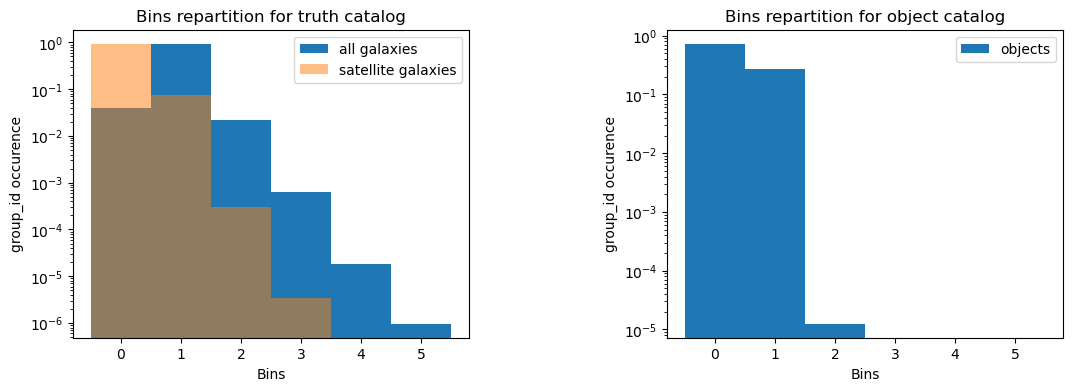

In [35]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1s=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2s=plt.hist(n_truth_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True, label='satellite galaxies')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for truth catalog')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for object catalog')

plt.show()

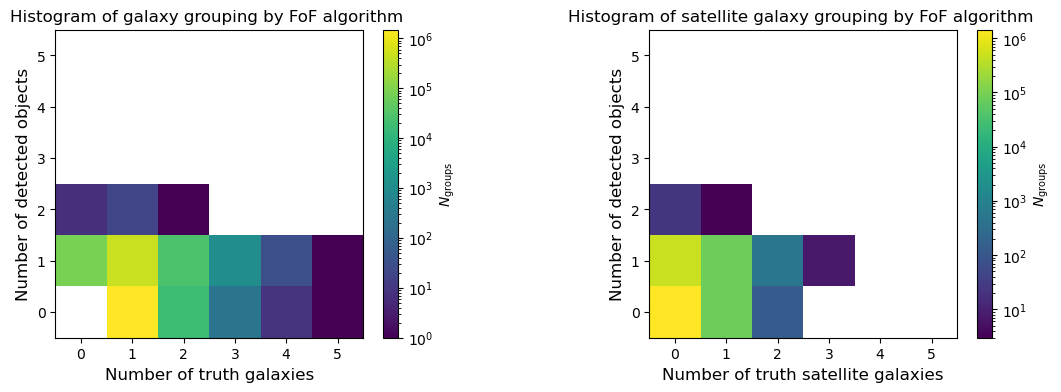

In [36]:
#average number of galaxies by groups : plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2sat=plt.hist2d(n_truth_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth_central))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth satellite galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of satellite galaxy grouping by FoF algorithm ')

plt.show()

#attention histo en échelles log

In [47]:
print("% of unrecognized blended groups for all galaxies (only for system 2-1) =", (hist2d1[0][2,1]/np.sum(hist2d1[0][:,1:]))*100)

print("% of unrecognized blended groups for satellite galaxies (only for system 2-1) =", (hist2d2sat[0][2,1]/np.sum(hist2d2central[0][:,1:]))*100 )

% of unrecognized blended groups for all galaxies (only for system 2-1) = 4.876190272245777
% of unrecognized blended groups for satellite galaxies (only for system 2-1) = 0.08904735391951119


In [49]:
print("% of recognized blended groups for all galaxies (for system 1-1) =", (hist2d1[0][1,1]/np.sum(hist2d1[0][:,1:]))*100)

print("% of recognized blended groups for satellite galaxies (for system 1-1) =", (hist2d2sat[0][1,1]/np.sum(hist2d2sat[0][:,1:]))*100 )

% of recognized blended groups for all galaxies (for system 1-1) = 80.15100575327993
% of recognized blended groups for satellite galaxies (for system 1-1) = 13.727925535711735


## Halo Mass Cut :

In [37]:
halo_mass_cut=1e14

In [38]:
ind_halo_mass_cut = np.where(truth_data['halo_mass']>halo_mass_cut)[0]   # pour se placer dans le régime des amas

In [39]:
len(ind_halo_mass_cut)

4454

In [40]:
#selection galaxies centrales (=halo) de masse > halo_mass_cut_choisit parmis toutes les galaxies centrales (qui, dans la simu, sont toutes des halos)

results[truth_mask][ind_galax_truth][np.where(truth_data['halo_mass']>halo_mass_cut)[0]]

row_index,catalog_key,group_id
int64,str6,int64
583798,galaxy,86022
896820,galaxy,86028
482659,galaxy,86030
1637664,galaxy,86031
1667048,galaxy,86031
1690355,galaxy,86032
482712,galaxy,86034
1068440,galaxy,86037
452128,galaxy,86040


In [41]:
n_truth_halo_mass_cut = np.bincount(results[truth_mask][ind_galax_truth][np.where(truth_data['halo_mass']>halo_mass_cut)[0]]['group_id'],
                                    minlength=n_groups)

In [42]:
n_truth_halo_mass_cut

array([0, 0, 0, ..., 0, 0, 0])

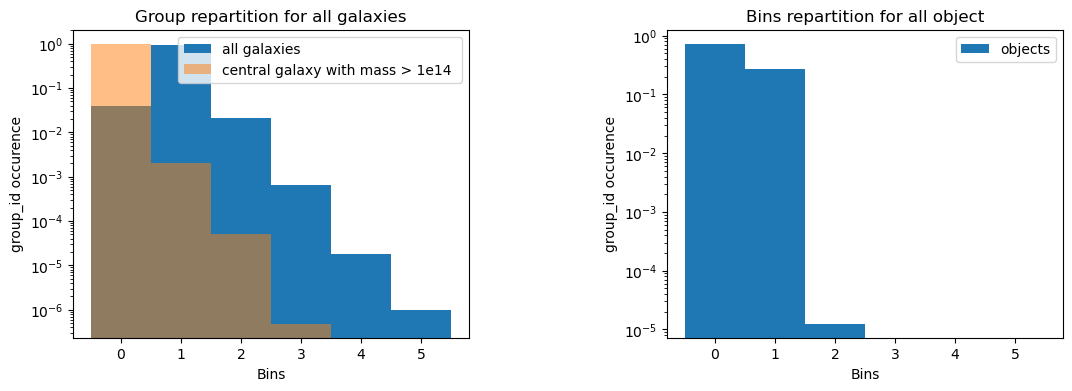

In [43]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'central galaxy with mass > 1e14 ')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Group repartition for all galaxies')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt.show()

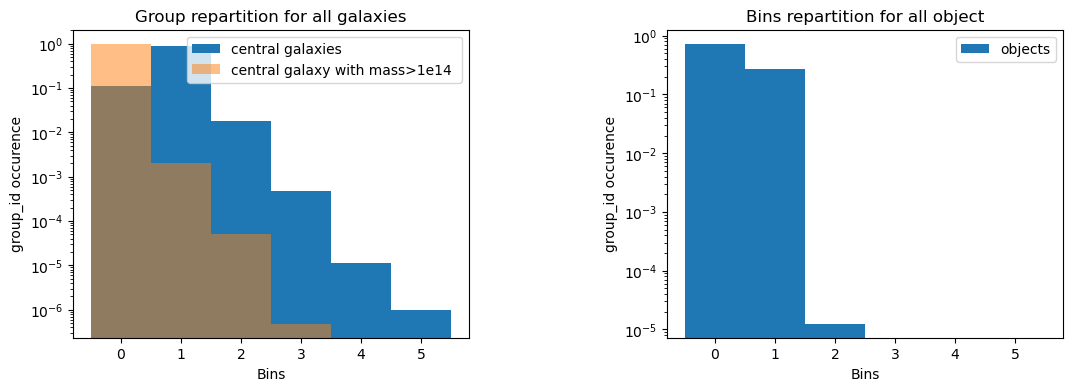

In [44]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1mass=plt.hist(n_truth_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="central galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'central galaxy with mass>1e14 ')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Group repartition for all galaxies')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt.show()

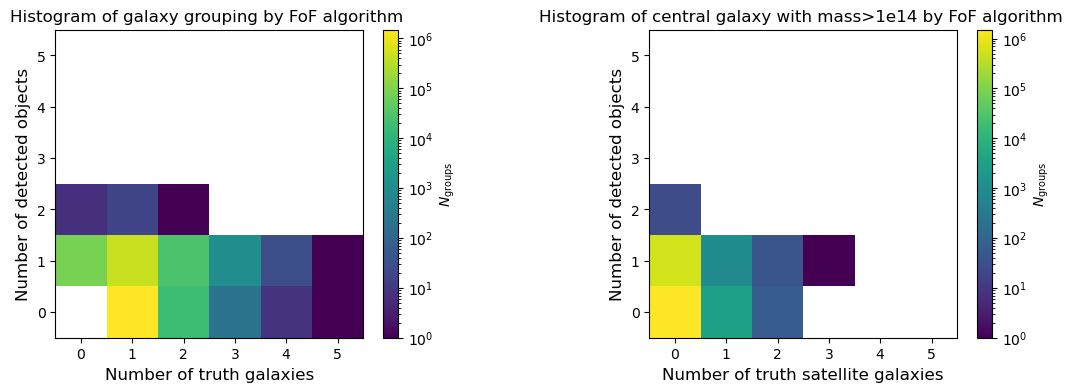

In [50]:
#average number of galaxies by groups : plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2mass=plt.hist2d(n_truth_halo_mass_cut, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth_central))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth satellite galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of central galaxy with mass>1e14 by FoF algorithm ')

plt.show()

#attention histo en échelles log

In [51]:
print("% of unrecognized blended groups for all galaxies (only for system 2-1) =", (hist2d1[0][2,1]/np.sum(hist2d1[0][:,1:]))*100)

print("% of unrecognized blended groups for satellite galaxies (only for system 2-1) =", (hist2d2mass[0][2,1]/np.sum(hist2d2mass[0][:,1:]))*100 )

% of unrecognized blended groups for all galaxies (only for system 2-1) = 4.876190272245777
% of unrecognized blended groups for satellite galaxies (only for system 2-1) = 0.00767341927562922
